# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List
from heapq import nsmallest

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> tuple[np.array, np.array]:
    df = pandas.read_csv(path_to_csv, header=0).sample(frac=1, ignore_index=True)
    X = df.drop(labels='label',axis=1)
    y = df.label.apply(lambda s: 1 if s=='M' else 0)
    X -= X.mean(0)
    X /= X.std(0)
    return np.array(X), np.array(y)

def read_spam_dataset(path_to_csv: str) -> tuple[np.array, np.array]:
    df = pandas.read_csv(path_to_csv, header=0).sample(frac=1, ignore_index=True)
    X = df.drop(labels='label',axis=1)
    y = df['label']
    X -= X.mean(0)
    X /= X.std(0)
    return np.array(X), np.array(y)

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [3]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    n = int(len(X) * ratio)
    X_train = X[:n]
    y_train = y[:n]
    X_test = X[n:]
    y_test = y[n:]
    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [4]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    classes = np.unique(np.concatenate((y_pred, y_true)))
    n = len(classes)
    true_pos = np.zeros(n, int)
    true_neg = np.zeros(n, int)
    false_pos = np.zeros(n, int)
    false_neg = np.zeros(n, int)
    for k, label in enumerate(classes):
        true_pos[k] = np.logical_and(y_true == label, y_pred == label).sum()
        true_neg[k] = np.logical_and(y_true != label, y_pred != label).sum()
        false_pos[k] = np.logical_and(y_true != label, y_pred == label).sum()
        false_neg[k] = np.logical_and(y_true == label, y_pred != label).sum()
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    accuracy = (y_true == y_pred).mean()
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [5]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [6]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачей во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [7]:
class KDNode:
    def __init__(self, ind: int, med: float, parent = None, dots = None):
        self.its_leaf = False
        self.parent = parent
        self.dots = dots
        if dots is None:
            self.index = ind
            self.med = med
            self.left = None
            self.right = None
        else:
            self.its_leaf = True


class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40, N: int = 10): 
        # N --- сколько фичей надо побробовать перед тем, как записать точки в один лист
        # по хорошему N = X.shape[1], но так очень долго считается 
        def meeting_parents(node, parent, left_child):
            if parent is not None:
                if left_child:
                    parent.left = node
                else:
                    parent.right = node
        
        def builder(i: int, indices: np.array, parent: KDNode, left_child: bool) -> KDNode:
            if sum(indices) < 2 * leaf_size:
                node = KDNode(0, 0, parent, indices)
                meeting_parents(node, parent, left_child)
                return node

            # поиск валидной фичи 
            for _ in range(N):
                med = np.median(self.X[indices, i], axis=0)
                left_indices = (self.X[:,i] < med) & indices
                right_indices = (self.X[:,i] >= med) & indices
                if min(sum(left_indices), sum(right_indices)) >= leaf_size:
                    break
                i = (i + 1) % N
            else:
                node = KDNode(0, 0, parent, indices)
                meeting_parents(node, parent, left_child)
                return node
            
            # запись узла и присоединение к дереву 
            node = KDNode(i, med, parent, indices)
            meeting_parents(node, parent, left_child)
            i = (i + 1) % N

            node.left = builder(i, left_indices, node, True)
            node.right = builder(i, right_indices, node, False)
            return node

        self.X = X
        m = self.X.shape[0]
        self.root = builder(0, np.array([True]*m), None, False)
    
    def query(self, X: np.array, k: int = 1) -> List[List]:
        # Евклидово расстояние между point и X[ind]
        def dist_to(point):
            def inner(ind): # I don't like anonymous functions
                return np.linalg.norm(self.X[ind] - point)
            return inner

        def merge(arr1: list, arr2: list, x) -> List:
            arr = []
            j_1 = 0
            j_2 = 0
            while j_1 < len(arr1) and j_2 < len(arr2):
                if dist_to(x)(arr1[j_1]) < dist_to(x)(arr2[j_2]):
                    arr.append(arr1[j_1])
                    j_1 += 1
                else:
                    arr.append(arr2[j_2])
                    j_2 += 1
            arr += arr1[j_1:] + arr2[j_2:]
            return arr[: k]

        def get_neighbors(x: np.array, node: KDNode) -> List:
            def sorted_dots(node):
                return nsmallest(k, np.where(node.dots)[0], key=dist_to(x))
            if node.its_leaf: return sorted_dots(node)

            ind, med = node.index, node.med
            first_path, second_path = (node.left, node.right) if x[ind] < med else (node.right, node.left)
            first_neighbors = get_neighbors(x, first_path)
            max_dist = first_neighbors[-1]
            if len(first_neighbors) == k and max_dist < abs(x[ind] - med):
                return first_neighbors
            second_neighbors = get_neighbors(x, second_path)
            return merge(first_neighbors, second_neighbors, x)

        neighbors = [[] for _ in X]
        for i, x in enumerate(X):
            neighbors[i] = get_neighbors(x, self.root)

        return neighbors

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [8]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(1000, 15)
X_test = np.random.randn(100, 15)
tree = KDTree(X_train, leaf_size=5) 

predicted = tree.query(X_test, k=20)
true = true_closest(X_train, X_test, k=20)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [9]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30): 
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size   
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:    
        self.X = X
        self.y = y
        self.labels = sorted(np.unique(y))
        self.tree = KDTree(self.X, self.leaf_size)
        
    def predict_proba(self, X: np.array) -> List[np.array]:
    
        predict_k_labels = self.y[self.tree.query(X, k=self.n_neighbors)]

        probability = np.zeros((X.shape[0], len(self.labels)))
        for i, l in enumerate(self.labels):
            probability[:, i] += (predict_k_labels == l).sum(1)
        probability /= self.n_neighbors
        return probability
        
    def predict(self, X: np.array) -> np.array:
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

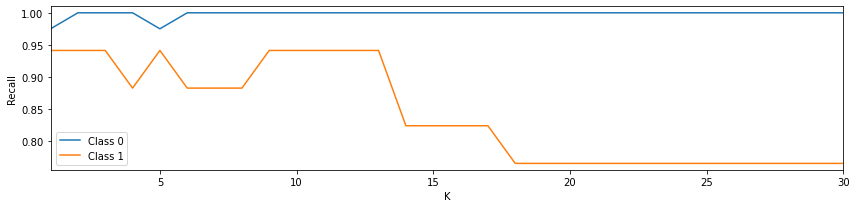

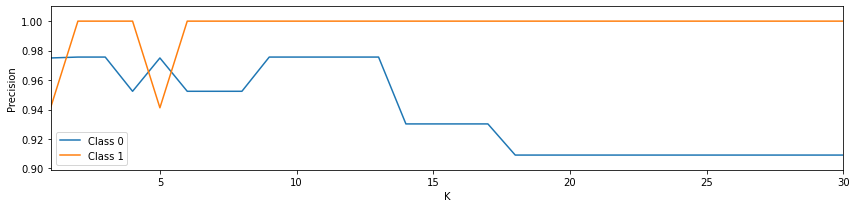

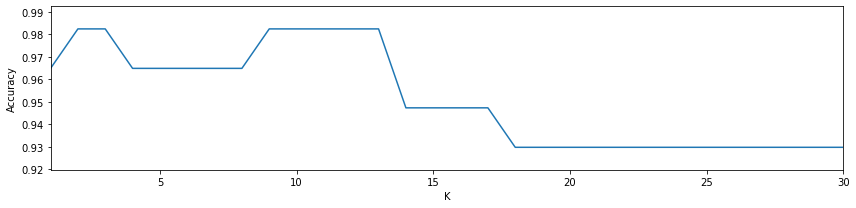

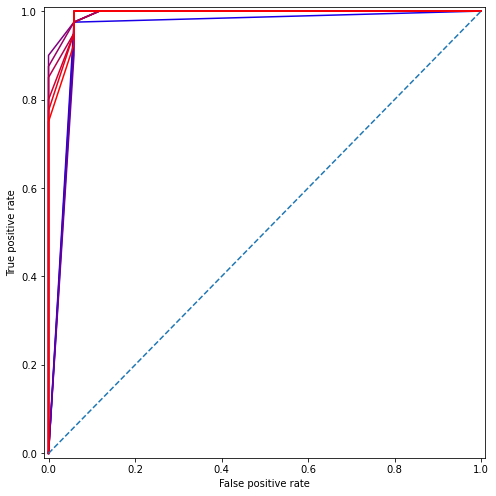

CPU times: user 8.55 s, sys: 19 ms, total: 8.57 s
Wall time: 8.62 s


In [10]:
%%time
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

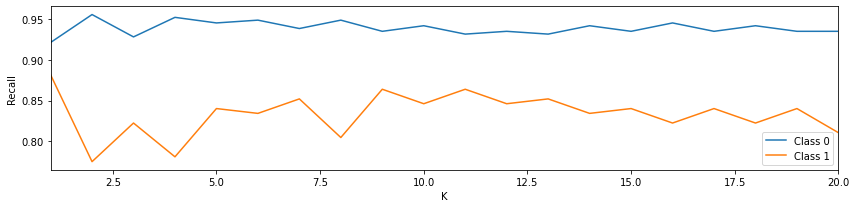

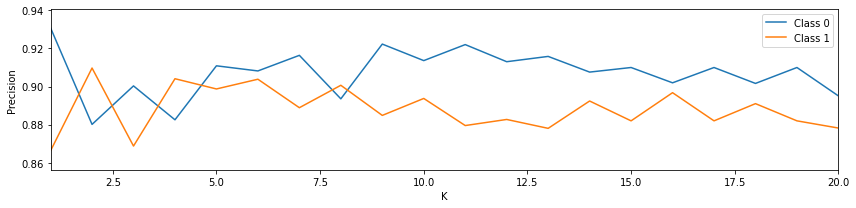

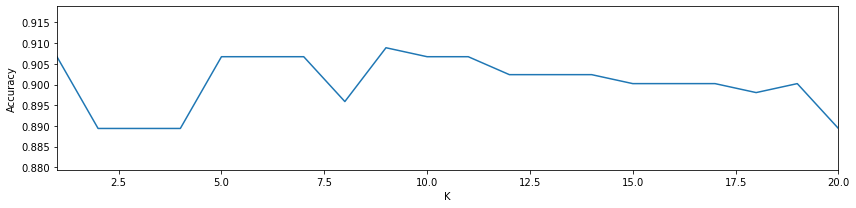

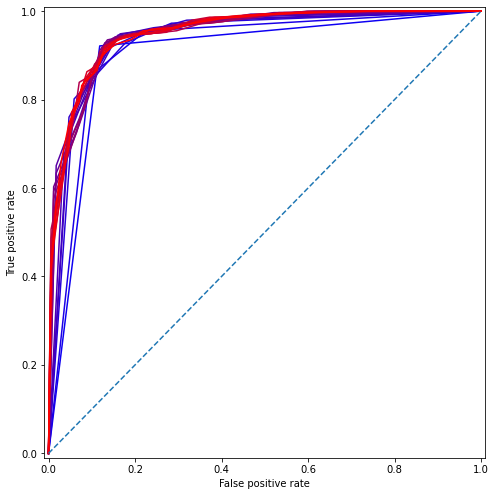

CPU times: user 5min 44s, sys: 188 ms, total: 5min 44s
Wall time: 5min 46s


In [11]:
%%time
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)